# `SMRT` class balancing via `AutoEncoder`s

SMRT (Sythetic Minority Reconstruction Technique) is the younger, more sophisticated cousin to SMOTE (Synthetic Minority Oversampling TEchnique). Using auto-encoders, SMRT learns the parameters that best reconstruct the observations in each minority class, and then generates synthetic observations until the minority class is represented at a minimum of ``balance_ratio`` * majority_class_size. 

SMRT avoids one of SMOTE's greatest risks: In SMOTE, when drawing random observations from whose k-nearest neighbors to reconstruct, the possibility exists that a "border point," or an observation very close to the decision boundary may be selected. This could result in the synthetically-generated observations lying too close to the decision boundary for reliable classification, and could lead to the degraded performance of an estimator. SMRT avoids this risk by ranking observations according to their reconstruction MSE, and drawing samples to reconstruct from the lowest-MSE observations (i.e., the most "phenotypical" of a class).


__Notebook purpose__:

Using the MNIST dataset (sampled in an imbalanced fashion with only 1s and 0s), this notebook will demonstrate the efficacy of SMRT's reconstructive balancing technique.

In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import smrt

# this is our seed
seed = 42

# show versions for continuity
print("TensorFlow version: %s" % tf.__version__)
print("NumPy version: %s" % np.__version__)
print("SMRT version: %s" % smrt.__version__)

TensorFlow version: 1.0.0
NumPy version: 1.11.1
SMRT version: 0.2


## Load MNIST

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Demonstrate the `AutoEncoder`

Before showing the result of the balancing technique, let's take a look at the `smrt.autoencode.AutoEncoder`. First we will split our data into train and test sets (we will not use the built-in MNIST test data).

In [3]:
# train test split
from sklearn.model_selection import train_test_split

all_data = np.asarray(mnist.train.images)
X_train, X_test = train_test_split(all_data, train_size=0.7, random_state=seed)

X_train.shape

(38500, 784)

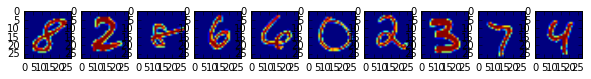

In [4]:
# matplotlib is way too into the whole "warn for everything"
import warnings

def suppress_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper


@suppress_warnings
def show_mnist(array_a, array_b=None, show=10, nrow=2, ncol=10, figsize=(10, 2)):
    # import without warnings
    from matplotlib import pyplot as plt
    %matplotlib inline
    
    if array_b is None:
        nrow = 1
        
    if nrow not in (1, 2):
        raise ValueError('nrow must be in (1, 2)')
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    for i in range(show):
        if nrow > 1:
            a[0][i].imshow(np.reshape(array_a[i], (28, 28)))
            a[1][i].imshow(np.reshape(array_b[i], (28, 28)))
        else:
            a[i].imshow(np.reshape(array_a[i], (28, 28)))
        
    f.show()
    plt.draw()
    
# draw some:
show_mnist(X_train)

## Fit and reconstruct using `AutoEncoder`

An AutoEncoder is a special case of a feed-forward neural network that attempts to learn a compressed feature space of the input tensor, and whose output layer seeks to reconstruct the original input. It is, therefore, a dimensionality reduction technique, on one hand, but can also be used for such tasks as de-noising and anomaly detection. It can be crudely thought of as similar to a "non-linear PCA."

The ``AutoEncoder`` class, as it is intended in ``smrt``, is used to ultimately identify the more minority-class-phenotypical training examples to "jitter" and reconstruct as synthetic training set observations.

In [8]:
from smrt.autoencode import AutoEncoder
from sklearn.metrics import mean_squared_error

# define
ae = AutoEncoder(n_epochs=10, learning_rate=0.01, batch_size=256, 
                 display_step=5, activation_function='sigmoid',
                 verbose=2, seed=seed)

# fit
ae.fit(X_train)

# transform and reconstruct the test images
reconstructed = ae.reconstruct(X_test)

# get the error:
mse = ((X_test - reconstructed) ** 2).sum(axis=1).sum() / X_test.shape[0]
print("\nTest MSE: %.4f" % mse)

Epoch: 1, cost=0.065526, time=2.4812 (sec)
Epoch: 6, cost=0.006480, time=2.6719 (sec)
Optimization complete after 10 epoch(s). Average epoch time: 2.6445 seconds

Test MSE: 3.6125


## Show reconstruction examples:

Top row is canonical; bottom row is reconstructed.

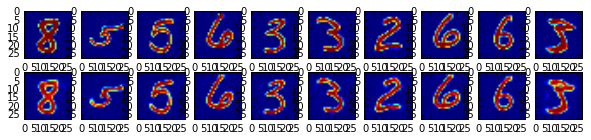

In [9]:
show_mnist(X_test, reconstructed)

*This looks pretty good!* It is illustrative of what a vanilla auto-encoder is capable of: identifying parameters that can be used to reconstruct its input. For data that does not follow the observed/learned patterns, it will have a hard time regenerating the input with a lower error.

However, the entire point of `SMRT` is the ability to create synthetic (never before seen) examples for your imbalanced datasets. The `AutoEncoder`, as shown here, is not a generative model&mdash;that is, it cannot generate new data on its own. However, there is a type of auto-encoder that can do just that: a __variational auto-encoder__.


# What can a `VariationalAutoEncoder` do about imbalance?

Let's create a situation where we have class imbalance (we'll use a dual class example for simplicity - 0/1). We will train a `smrt.autoencode.VariationalAutoEncoder` instance to generate hand-written __ones__ that resemble those in the MNIST dataset.

In [5]:
# they're one-hot encoded right now. Flatten into a single vector
labels = np.asarray([np.argmax(row) for row in mnist.train.labels])
labels

array([7, 3, 4, ..., 5, 6, 8])

In [6]:
# create masks
one_mask = labels == 1
zero_mask = labels == 0
minority_size = 1000

# get labels
y_ones = labels[one_mask][:minority_size]  # make this minority
y_zeros = labels[zero_mask]

# get images
X_ones = all_data[one_mask, :][:minority_size]  # make this minority
X_zeros = all_data[zero_mask, :]

# view shapes
print('Minority size: %i' % y_ones.shape)
print('Majority size: %i' % y_zeros.shape)

Minority size: 1000
Majority size: 5444


## Data prep

Concatenate our arrays together:

In [7]:
X = np.vstack([X_ones, X_zeros])
y = np.concatenate([y_ones, y_zeros])

## Observe a `VariationalAutoEncoder`'s generative ability


Before balancing the data, let's look at just what the `VariationalAutoEncoder` is capable of...

In [8]:
from smrt.autoencode import VariationalAutoEncoder

# define and fit the encoder
v_encoder = VariationalAutoEncoder(n_epochs=10, learning_rate=0.01, batch_size=256, 
                                   display_step=5, activation_function='sigmoid',
                                   verbose=2, n_latent_factors=50, seed=seed)

v_encoder.fit(X_ones)

# Generate fake data:


ValueError: Dimensions must be equal, but are 50 and 470 for 'MatMul_3' (op: 'MatMul') with input shapes: [256,50], [470,784].

## Perform SMRT balancing

Let's balance our minority class up to a ratio of 50% of the majority class' representation:

In [10]:
from smrt import smrt_balance

X_smrt, y_smrt = smrt_balance(X, y, seed=seed, shuffle=False, balance_ratio=0.5)

KeyboardInterrupt: 

In [ ]:
# Let's view some of our reconstructed ONEs:
show_mnist(X_smrt[-10:], X_smrt[-20:-10])

# How does `SMRT` stack up to `SMOTE`?

Again, the precept of SMRT is that it avoids one of SMOTE's greatest risks: In SMOTE, when drawing random observations from whose k-nearest neighbors to reconstruct, the possibility exists that a "border point," or an observation very close to the decision boundary may be selected. This could result in the synthetically-generated observations lying too close to the decision boundary for reliable classification, and could lead to the degraded performance of an estimator. SMRT avoids this risk, by ranking observations according to their reconstruction MSE, and drawing samples to reconstruct from the lowest-MSE observations (i.e., the most "phenotypical" of a class).

Thus, we should take a look at how SMOTE & SMRT stack up on the same problem.

In [10]:
from smrt.balance import smote_balance

X_smote, y_smote = smote_balance(X, y, seed=seed, n_neighbors=10, 
                                 shuffle=False, balance_ratio=0.5)

ValueError: need at least one array to concatenate

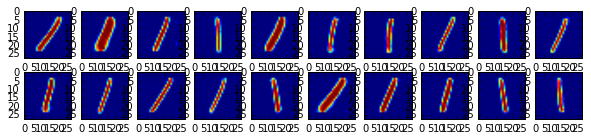

In [27]:
# Let's view some of our interpolated ONEs:
show_mnist(X_smote[-10:], X_smote[-20:-10])

## Fit classifiers against each balanced set:

Our hypothesis is that a classifier should work more accurately and robustly against a dataset balanced using SMRT than by one using SMOTE. Let's see how an SVM performs on the result of each balancing operation.

In [28]:
# split our balanced sets - 
X_train_smrt, X_test_smrt, y_train_smrt, y_test_smrt = train_test_split(X_smrt, y_smrt, 
                                                                        train_size=0.7, 
                                                                        random_state=seed)

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, 
                                                                            train_size=0.7, 
                                                                            random_state=seed)

X_train_imbal, X_test_imbal, y_train_imbal, y_test_imbal = train_test_split(X, y, train_size=0.7,
                                                                            random_state=seed)

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# just use default params for each
imbalanced_svm = SVC().fit(X_train_imbal, y_train_imbal)
smote_svm = SVC().fit(X_train_smote, y_train_smote)
smrt_svm = SVC().fit(X_train_smrt, y_train_smrt)

# view performance
print("Imbalanced test accuracy: %.5f" % accuracy_score(imbalanced_svm.predict(X_test_imbal), y_test_imbal))
print("SMOTE test accuracy: %.5f" % accuracy_score(smote_svm.predict(X_test_smote), y_test_smote))
print("SMRT test accuracy: %.5f" % accuracy_score(smrt_svm.predict(X_test_smrt), y_test_smrt))

Imbalanced test accuracy: 0.99690
SMOTE test accuracy: 0.99918
SMRT test accuracy: 0.99837


__What could improve performance even further?__

SMRT has a *lot* more tuning knobs than SMOTE does. More epochs, lower learning rate, a different activation function, varied jitter amount... all of the above and more can have a dramatic impact on the reconstructive capability of SMRT. Furthermore, SMRT requires *__lots__* of data since it's a series of neural networks. Low-rank or small data may perform extremely poorly in the autoencoder (for example, try it on iris...). In these cases, SMOTE may be the preferable option.